# Convolutional Neural Network

In [3]:
import torch
import numpy as np

### Load data

Load training and test data, split the training data into training and validation sets, then create a `DataLoader` for each dataset.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# Load 16 images per batch
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2

# Convert the data to torch.FloatTensor and normalize.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Select training and testing data
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# 10 categories in image classification
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


### View a batch of samples in the training set

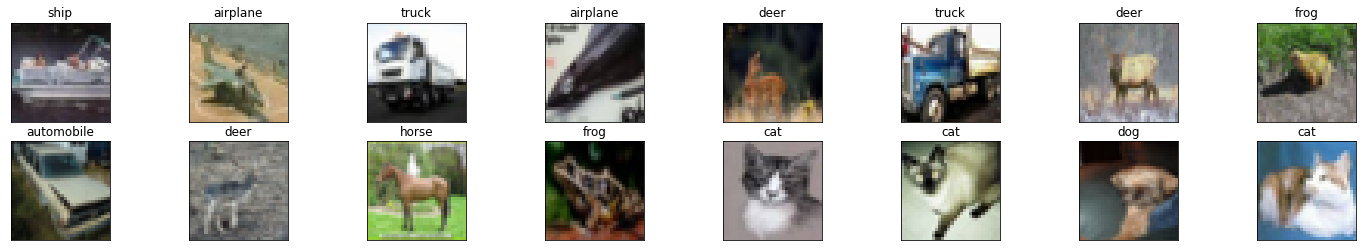

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# get a batch of sample
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# show image and its classification
fig = plt.figure(figsize=(25, 4))
# show 16 pictures
for idx in np.arange(16):
    ax = fig.add_subplot(int(2), int(16/2), idx+1, xticks=[], yticks=[])
    
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


### See more details in one image
Here, normalization is done. The red, green, and blue (RGB) color channels can be viewed as three separate grayscale images.

In [15]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (40, 40),dpi = 500) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='viridis')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')


### Defining the structure of a convolutional neural network

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv (32x32x3 image)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # conv(16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # conv(8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout (p=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


### Choosing a Loss Function and an Optimization Function

In [17]:
import torch.optim as optim
# Use the cross entropy loss function
criterion = nn.CrossEntropyLoss()
# Using stochastic gradient descent, learning rate lr=0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Train a Convolutional Neural Network Model
The loss on training and validation sets decreases over time; if the validation loss keeps increasing, it indicates possible overfitting. (In fact, in the example below, if n_epochs is set to 40, it can be found that there is overfitting)

In [19]:
# traing time
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Training set model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # Test set model #
    ######################
    model.eval()
    for data, target in valid_loader:

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # Show loss functions for training and validation sets 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # If the validation loss function decreases, save the model.
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 1.611321 	Validation Loss: 1.438559
Validation loss decreased (inf --> 1.438559).  Saving model ...
Epoch: 2 	Training Loss: 1.446840 	Validation Loss: 1.307395
Validation loss decreased (1.438559 --> 1.307395).  Saving model ...
Epoch: 3 	Training Loss: 1.323339 	Validation Loss: 1.188035
Validation loss decreased (1.307395 --> 1.188035).  Saving model ...
Epoch: 4 	Training Loss: 1.221385 	Validation Loss: 1.090798
Validation loss decreased (1.188035 --> 1.090798).  Saving model ...
Epoch: 5 	Training Loss: 1.132093 	Validation Loss: 1.031089
Validation loss decreased (1.090798 --> 1.031089).  Saving model ...
Epoch: 6 	Training Loss: 1.054841 	Validation Loss: 0.979977
Validation loss decreased (1.031089 --> 0.979977).  Saving model ...
Epoch: 7 	Training Loss: 0.988613 	Validation Loss: 0.918028
Validation loss decreased (0.979977 --> 0.918028).  Saving model ...
Epoch: 8 	Training Loss: 0.937360 	Validation Loss: 0.875455
Validation loss decreased (0.91802

In [20]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

### Test the trained network
A "good" result would be that the CNN gets about 70% accuracy on these test images

In [23]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.691042

Test Accuracy of airplane: 79% (799/1000)
Test Accuracy of automobile: 89% (894/1000)
Test Accuracy of  bird: 67% (676/1000)
Test Accuracy of   cat: 57% (573/1000)
Test Accuracy of  deer: 75% (752/1000)
Test Accuracy of   dog: 60% (600/1000)
Test Accuracy of  frog: 87% (871/1000)
Test Accuracy of horse: 78% (781/1000)
Test Accuracy of  ship: 88% (889/1000)
Test Accuracy of truck: 81% (817/1000)

Test Accuracy (Overall): 76% (7652/10000)


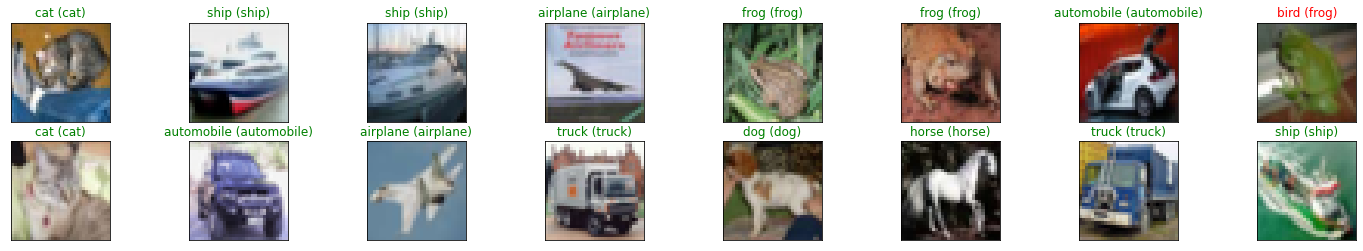

In [26]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()



# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
